## About the data

#### Description
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('breast_cancer.csv')

### Target_column is Diagnosis

In [5]:
data.diagnosis.unique()


array(['M', 'B'], dtype=object)

In [6]:
data.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [7]:
#It is a imbalanced dataset

#### Checking for the missing values

In [9]:
data.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [11]:
features = data.drop(columns= ['id', 'diagnosis', 'Unnamed: 32'])

#### Checking for numerical and catagorical values

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [16]:
data.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [17]:
data.diagnosis = data.diagnosis.map({'M':1, 'B':0})

In [20]:
TARGET_COL = 'diagnosis'
target = data[TARGET_COL]

#### Baseline model

Trying with the Randomforest algo

In [18]:
re = RandomForestClassifier()

In [67]:
trainX, testX, trainY, testY = train_test_split(data[features.columns],data.diagnosis)

In [23]:
re.fit(trainX, trainY)
re.score(testX, testY)

0.958041958041958

 Trying with Logistic regression

In [26]:
le = LogisticRegression()
le.fit(trainX, trainY)
le.score(testX, testY)

/home/paramathma/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.951048951048951

In [27]:
de = DecisionTreeClassifier()
de.fit(trainX,trainY)
de.score(testX, testY)

0.9370629370629371

##### AS a baseline model Randoom forest is giving the highest score hence going for improving the accuracy with Hyperparameter tuning

### Hyperparameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [31]:
params =  {
    'n_estimators': [50,100, 150, 200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

In [38]:
Rs = RandomizedSearchCV(estimator= RandomForestClassifier(), param_distributions= params, random_state=1)
Rs.fit(trainX, trainY)


RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'class_weight': [{0: 1, 1: 1},
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3},
                                                         {0: 1, 1: 4},
                                                         {0: 1, 1: 5}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 8, 10, 12],
                                        'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                                        'max_leaf_nodes': [8, 16, 32, 64, 128],
                                        'min_samples_split': [2, 10, 20, 30,
                                                              40],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         

In [45]:
params = Rs.best_params_

In [46]:
Rs.score(testX, testY)

0.951048951048951

In [41]:
re = RandomForestClassifier(random_state=1, **params)

In [42]:
re.fit(trainX,trainY)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=10, max_features=1,
                       max_leaf_nodes=32, min_samples_split=30,
                       n_estimators=500, random_state=1)

In [43]:
re.score(testX, testY)

0.958041958041958

### Trying with advanced algo i.e is LightBGM

In [49]:
lg = LGBMClassifier(random_state=1)
lg.fit(trainX, trainY)
lg.score(testX, testY)

0.965034965034965

#### After the Hyperparameter tuning also the scores has not improved. Hence going for Kfold or stratagic fold validation technique

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [54]:
def run_clf(clf, train, features):
    oops = np.zeros(len(train))
   
    n_splits = 5
    folds = StratifiedKFold(n_splits= n_splits)
    for folds_, (train_index, val_index) in enumerate (folds.split(train, train[TARGET_COL])):
        trainX, trainY = train[features.columns].iloc[train_index], target.iloc[train_index]
        testX, testY = train[features.columns].iloc[val_index], target.iloc[val_index]
       
    
        _ = clf.fit(trainX, trainY)
        
        f1score = f1_score(testY,clf.predict(testX))
        
        print('f1 score on validation test', f1score)
        val_predicts = clf.predict_proba(testX)[:,1]
       
        
        oops[val_index] = val_predicts
      
        
    oops_score = f1_score(target, oops.round())
    print('oops f1-score', oops_score)
    
    return oops 
    

In [55]:
run_clf(lg, data, features)

f1 score on validation test 0.9195402298850575
f1 score on validation test 0.9523809523809524
f1 score on validation test 0.975609756097561
f1 score on validation test 0.9647058823529412
f1 score on validation test 0.9647058823529412
oops f1-score 0.9550827423167848


array([9.99619191e-01, 9.99881382e-01, 9.99973277e-01, 9.94009314e-01,
       9.99406037e-01, 9.94612430e-01, 9.99958719e-01, 9.96824387e-01,
       9.99679377e-01, 9.96978421e-01, 9.67789676e-01, 9.99946636e-01,
       9.99905560e-01, 5.21261892e-01, 9.98902603e-01, 9.99915533e-01,
       9.99949232e-01, 9.99970965e-01, 9.99974220e-01, 1.12969274e-03,
       5.14269371e-05, 1.63719157e-05, 9.98609103e-01, 9.99966374e-01,
       9.99971712e-01, 9.99932320e-01, 9.99911358e-01, 9.99247101e-01,
       9.99971098e-01, 9.42004019e-01, 9.99970707e-01, 9.96863316e-01,
       9.99971924e-01, 9.99974047e-01, 9.99961432e-01, 9.99971430e-01,
       9.87107769e-01, 2.25814421e-04, 3.23442276e-01, 9.89272575e-01,
       4.95944911e-03, 2.17166242e-02, 9.99902332e-01, 9.91477086e-01,
       9.96240035e-01, 9.99943047e-01, 3.57361011e-05, 9.98937706e-01,
       9.06040925e-04, 7.52736373e-02, 3.63313914e-05, 8.73034473e-05,
       7.30454153e-05, 9.99543505e-01, 9.93372405e-01, 9.81439247e-04,
      

#### Threshold setting

In [57]:
def get_optimal_f1thresold(target, oops):
    threshold = np.arange(0,100)/100
    threshold_score= []
    for thre in threshold:
        oops_rounded = (oops>thre)*1
        f1score = f1_score(target, oops_rounded)
        threshold_score.append(f1score)
    optimal_thre = pd.Series(data=threshold_score, index= threshold)
    optimal_thre.plot(figsize=(10, 6), fontsize=14)
  
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    return optimal_thre.sort_values(ascending=False)[0]

In [58]:
from sklearn.metrics import accuracy_score

f1 score on validation test 0.9195402298850575
f1 score on validation test 0.9523809523809524
f1 score on validation test 0.975609756097561
f1 score on validation test 0.9647058823529412
f1 score on validation test 0.9647058823529412
oops f1-score 0.9550827423167848
predicted accuracy 0.968365553602812
optimal threshold value 0.5428937259923176


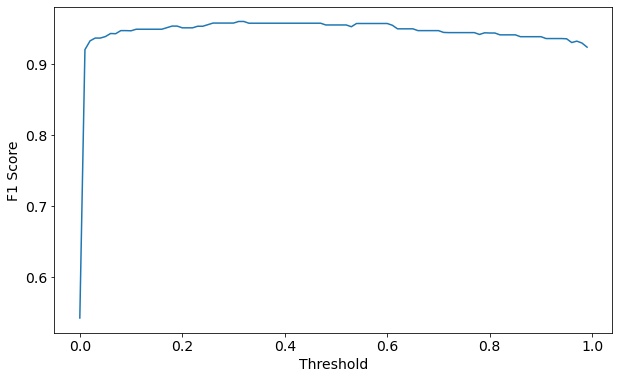

In [62]:
oops = run_clf(lg, data, features)
optimal_value = get_optimal_f1thresold(target, oops)
# print('test score',lg.score(target, oops))
print('predicted accuracy', accuracy_score(target, (oops>optimal_value)*1))
print('optimal threshold value', optimal_value)

#### AT threshold value .54 we are able to achive accuracy of 96.8% .. further improving the model

#### Since there is no change in scores hence we are tuning the Lightgbm classifer for improvement

In [64]:
def run_gradient_boosting(clf, fit_params, train,  features):
    N_SPLITS = 5
    oofs = np.zeros(len(train))
    
    folds = StratifiedKFold(n_splits = N_SPLITS)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')

        ### Training Set
        X_trn, y_trn = train[features.columns].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features.columns].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
    

        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        

        _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict_proba(X_val)[:, 1]
        

        fold_score = f1_score(y_val, preds_val.round())
        print(f'\nF1 score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
     


    oofs_score = f1_score(target, oofs.round())
    print(f'\n\nF1 score for oofs is {oofs_score}')

    return oofs


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.138403

F1 score for validation set is 0.9069767441860465

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.141324

F1 score for validation set is 0.9397590361445783

------------- Fold 3 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0327618

F1 score for validation set is 0.9879518072289156

------------- Fold 4 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's binary_logloss: 0.103295

F1 score for validation set is 0.963855421686747

------------- Fold 5 -------------
Training until v

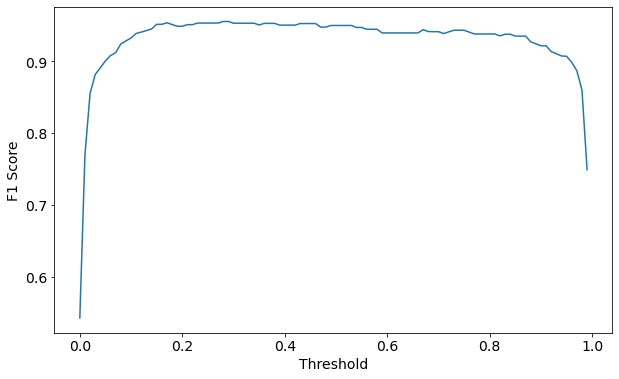

In [65]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs = run_gradient_boosting(lg, fit_params,data, features)

optimal_thresh = get_optimal_f1thresold(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized acuuracy {optimized_f1}')

### From This LGM we are able to get upto 96.8% of accuracy. trying with another algo .i.e is XGBOOST and CATBOOSt

In [71]:
cg = CatBoostClassifier()
cg.fit(trainX, trainY)
a= accuracy_score(cg.predict(testX), testY)

Learning rate set to 0.007156
0:	learn: 0.6816739	total: 8.61ms	remaining: 8.6s
1:	learn: 0.6693383	total: 14ms	remaining: 6.97s
2:	learn: 0.6581787	total: 19ms	remaining: 6.33s
3:	learn: 0.6475371	total: 24.3ms	remaining: 6.04s
4:	learn: 0.6356803	total: 30.2ms	remaining: 6.02s
5:	learn: 0.6266727	total: 35.4ms	remaining: 5.87s
6:	learn: 0.6144089	total: 40.5ms	remaining: 5.74s
7:	learn: 0.6029186	total: 45.7ms	remaining: 5.67s
8:	learn: 0.5915639	total: 50.9ms	remaining: 5.6s
9:	learn: 0.5819168	total: 56ms	remaining: 5.54s
10:	learn: 0.5712772	total: 61.6ms	remaining: 5.53s
11:	learn: 0.5622891	total: 66.7ms	remaining: 5.49s
12:	learn: 0.5529120	total: 71.8ms	remaining: 5.45s
13:	learn: 0.5442938	total: 76.9ms	remaining: 5.42s
14:	learn: 0.5354462	total: 82ms	remaining: 5.39s
15:	learn: 0.5261098	total: 87.2ms	remaining: 5.36s
16:	learn: 0.5174668	total: 92.2ms	remaining: 5.33s
17:	learn: 0.5092778	total: 97.4ms	remaining: 5.31s
18:	learn: 0.5010882	total: 103ms	remaining: 5.29s
19:

175:	learn: 0.0886336	total: 988ms	remaining: 4.63s
176:	learn: 0.0877320	total: 995ms	remaining: 4.62s
177:	learn: 0.0870772	total: 1s	remaining: 4.62s
178:	learn: 0.0865455	total: 1.01s	remaining: 4.63s
179:	learn: 0.0859477	total: 1.01s	remaining: 4.63s
180:	learn: 0.0855187	total: 1.02s	remaining: 4.62s
181:	learn: 0.0851324	total: 1.03s	remaining: 4.61s
182:	learn: 0.0844102	total: 1.03s	remaining: 4.61s
183:	learn: 0.0839106	total: 1.04s	remaining: 4.6s
184:	learn: 0.0831555	total: 1.04s	remaining: 4.59s
185:	learn: 0.0826698	total: 1.05s	remaining: 4.58s
186:	learn: 0.0823945	total: 1.05s	remaining: 4.58s
187:	learn: 0.0818873	total: 1.06s	remaining: 4.57s
188:	learn: 0.0812297	total: 1.06s	remaining: 4.56s
189:	learn: 0.0806041	total: 1.07s	remaining: 4.56s
190:	learn: 0.0801407	total: 1.07s	remaining: 4.55s
191:	learn: 0.0797220	total: 1.08s	remaining: 4.54s
192:	learn: 0.0791856	total: 1.08s	remaining: 4.54s
193:	learn: 0.0785867	total: 1.09s	remaining: 4.53s
194:	learn: 0.07

357:	learn: 0.0371006	total: 1.99s	remaining: 3.58s
358:	learn: 0.0370280	total: 2s	remaining: 3.57s
359:	learn: 0.0369088	total: 2.01s	remaining: 3.57s
360:	learn: 0.0368248	total: 2.01s	remaining: 3.56s
361:	learn: 0.0367575	total: 2.02s	remaining: 3.56s
362:	learn: 0.0367322	total: 2.02s	remaining: 3.55s
363:	learn: 0.0366018	total: 2.03s	remaining: 3.55s
364:	learn: 0.0364973	total: 2.04s	remaining: 3.54s
365:	learn: 0.0364222	total: 2.04s	remaining: 3.54s
366:	learn: 0.0362969	total: 2.05s	remaining: 3.53s
367:	learn: 0.0361067	total: 2.05s	remaining: 3.52s
368:	learn: 0.0359332	total: 2.06s	remaining: 3.52s
369:	learn: 0.0357705	total: 2.06s	remaining: 3.51s
370:	learn: 0.0355247	total: 2.07s	remaining: 3.5s
371:	learn: 0.0353668	total: 2.07s	remaining: 3.5s
372:	learn: 0.0351956	total: 2.08s	remaining: 3.49s
373:	learn: 0.0350786	total: 2.08s	remaining: 3.49s
374:	learn: 0.0350314	total: 2.09s	remaining: 3.48s
375:	learn: 0.0349862	total: 2.09s	remaining: 3.47s
376:	learn: 0.034

533:	learn: 0.0226176	total: 2.99s	remaining: 2.61s
534:	learn: 0.0225758	total: 3s	remaining: 2.6s
535:	learn: 0.0225062	total: 3s	remaining: 2.6s
536:	learn: 0.0224511	total: 3.01s	remaining: 2.6s
537:	learn: 0.0223647	total: 3.02s	remaining: 2.59s
538:	learn: 0.0223257	total: 3.02s	remaining: 2.59s
539:	learn: 0.0222625	total: 3.03s	remaining: 2.58s
540:	learn: 0.0222461	total: 3.04s	remaining: 2.58s
541:	learn: 0.0221867	total: 3.04s	remaining: 2.57s
542:	learn: 0.0221601	total: 3.05s	remaining: 2.56s
543:	learn: 0.0220988	total: 3.05s	remaining: 2.56s
544:	learn: 0.0220041	total: 3.06s	remaining: 2.55s
545:	learn: 0.0219711	total: 3.06s	remaining: 2.55s
546:	learn: 0.0219310	total: 3.07s	remaining: 2.54s
547:	learn: 0.0218816	total: 3.08s	remaining: 2.54s
548:	learn: 0.0218093	total: 3.08s	remaining: 2.53s
549:	learn: 0.0217396	total: 3.09s	remaining: 2.53s
550:	learn: 0.0217006	total: 3.09s	remaining: 2.52s
551:	learn: 0.0216145	total: 3.1s	remaining: 2.51s
552:	learn: 0.0215519	

710:	learn: 0.0153324	total: 3.99s	remaining: 1.62s
711:	learn: 0.0153073	total: 4s	remaining: 1.62s
712:	learn: 0.0152838	total: 4s	remaining: 1.61s
713:	learn: 0.0152669	total: 4.01s	remaining: 1.61s
714:	learn: 0.0152090	total: 4.02s	remaining: 1.6s
715:	learn: 0.0151903	total: 4.02s	remaining: 1.6s
716:	learn: 0.0151553	total: 4.03s	remaining: 1.59s
717:	learn: 0.0151328	total: 4.03s	remaining: 1.58s
718:	learn: 0.0150978	total: 4.04s	remaining: 1.58s
719:	learn: 0.0150581	total: 4.04s	remaining: 1.57s
720:	learn: 0.0150182	total: 4.05s	remaining: 1.57s
721:	learn: 0.0149703	total: 4.06s	remaining: 1.56s
722:	learn: 0.0149181	total: 4.06s	remaining: 1.56s
723:	learn: 0.0149010	total: 4.07s	remaining: 1.55s
724:	learn: 0.0148617	total: 4.07s	remaining: 1.54s
725:	learn: 0.0148325	total: 4.08s	remaining: 1.54s
726:	learn: 0.0147977	total: 4.08s	remaining: 1.53s
727:	learn: 0.0147935	total: 4.09s	remaining: 1.53s
728:	learn: 0.0147731	total: 4.09s	remaining: 1.52s
729:	learn: 0.014760

893:	learn: 0.0112525	total: 4.99s	remaining: 591ms
894:	learn: 0.0112361	total: 4.99s	remaining: 586ms
895:	learn: 0.0112092	total: 5s	remaining: 580ms
896:	learn: 0.0112050	total: 5.01s	remaining: 575ms
897:	learn: 0.0112039	total: 5.01s	remaining: 569ms
898:	learn: 0.0112019	total: 5.02s	remaining: 564ms
899:	learn: 0.0111782	total: 5.02s	remaining: 558ms
900:	learn: 0.0111695	total: 5.03s	remaining: 553ms
901:	learn: 0.0111489	total: 5.04s	remaining: 547ms
902:	learn: 0.0111460	total: 5.04s	remaining: 541ms
903:	learn: 0.0111418	total: 5.05s	remaining: 536ms
904:	learn: 0.0111199	total: 5.05s	remaining: 530ms
905:	learn: 0.0111145	total: 5.06s	remaining: 525ms
906:	learn: 0.0111123	total: 5.06s	remaining: 519ms
907:	learn: 0.0110835	total: 5.07s	remaining: 514ms
908:	learn: 0.0110817	total: 5.07s	remaining: 508ms
909:	learn: 0.0110796	total: 5.08s	remaining: 502ms
910:	learn: 0.0110773	total: 5.08s	remaining: 497ms
911:	learn: 0.0110508	total: 5.09s	remaining: 491ms
912:	learn: 0.0


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.138403

F1 score for validation set is 0.9069767441860465

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.141324

F1 score for validation set is 0.9397590361445783

------------- Fold 3 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0327618

F1 score for validation set is 0.9879518072289156

------------- Fold 4 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's binary_logloss: 0.103295

F1 score for validation set is 0.963855421686747

------------- Fold 5 -------------
Training until v

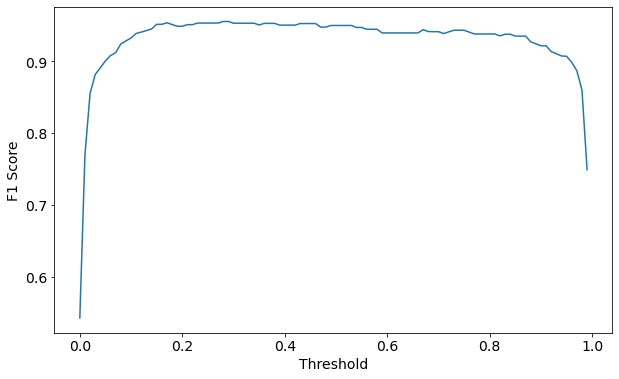

In [74]:
clf = CatBoostClassifier(n_estimators = 3000,
                        
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs = run_gradient_boosting(lg, fit_params,data, features)

optimal_thresh = get_optimal_f1thresold(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized acuuracy {optimized_f1}')

In [76]:
xg =XGBClassifier()
xg.fit(trainX, trainY)
xg.score(testX,testY)

0.958041958041958

#### Logistic Regression


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binary_logloss: 0.138403

F1 score for validation set is 0.9069767441860465

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.141324

F1 score for validation set is 0.9397590361445783

------------- Fold 3 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's binary_logloss: 0.0327618

F1 score for validation set is 0.9879518072289156

------------- Fold 4 -------------
Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's binary_logloss: 0.103295

F1 score for validation set is 0.963855421686747

------------- Fold 5 -------------
Training until v

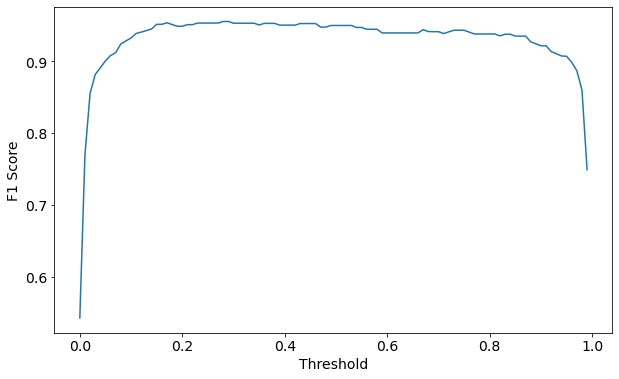

In [79]:
clf = LogisticRegression(
                        
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs = run_gradient_boosting(lg, fit_params,data, features)

optimal_thresh = get_optimal_f1thresold(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized acuuracy {optimized_f1}')

Since all other algo stopped at the 96% only catboost has 1% more accuracy when compared to other

#### Conclusion :

WE will be selecting the baseline CATboost model as the best model  which has produced the accuracy oof 97%